# Build a SeqData

In [1]:
# Imports
import os
import numpy as np
import seqdata as sd

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [7]:
# TODO: change to your path
data_dir = "/cellar/users/aklie/data/datasets/K562_ATAC-seq/data"

In [8]:
# Set-up paths
peaks = os.path.join(data_dir, "ENCSR868FGK_K562_ATAC-seq_peaks.bed")
signal = os.path.join(data_dir, "K562_ATAC-seq_unstranded_counts.bw")
fasta = os.path.join(data_dir, "hg38.fa")
peaks, signal

('/cellar/users/aklie/data/datasets/K562_ATAC-seq/data/peaks.bed',
 '/cellar/users/aklie/data/datasets/K562_ATAC-seq/data/signal.bw')

In [9]:
# Make output directory if doesn't exist
out = os.path.join(data_dir, "K562_ATAC-seq.zarr")
out

'/cellar/users/aklie/data/datasets/K562_ATAC-seq/data/K562_ATAC-seq.zarr'

In [10]:
# Build SeqData
sdata = sd.from_region_files(
    sd.GenomeFASTA('seq',
        fasta,
        batch_size=10000,
        n_threads=4,
    ),
    sd.BigWig(
        'cov',
        [signal],
        ["K562_ATAC-seq"],
        batch_size=10000,
        n_jobs=4,
        threads_per_job=2,
    ),
    path=out,
    fixed_length=2114,
    bed=peaks,
    overwrite=True,
    max_jitter=128
)
sdata.load()

100%|██████████| 269800/269800 [00:35<00:00, 7632.87it/s] 
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|██████████| 269800/269800 [02:07<00:00, 2111.88it/s]


<xarray.Dataset>
Dimensions:     (_sequence: 269800, cov_sample: 1, _length: 2370)
Coordinates:
  * cov_sample  (cov_sample) object 'K562_ATAC-seq'
Dimensions without coordinates: _sequence, _length
Data variables:
    blockCount  (_sequence) uint64 1291 89 688 479 1078 ... 101 93 246 127 235
    chrom       (_sequence) object 'chr1' 'chr1' 'chr1' ... 'chrY' 'chrY' 'chrY'
    chromEnd    (_sequence) int64 100029914 100029914 ... 18994113 4032056
    chromStart  (_sequence) int64 100027544 100027544 ... 18991743 4029686
    cov         (_sequence, cov_sample, _length) float32 0.0 0.0 0.0 ... 0.0 0.0
    itemRgb     (_sequence) object '35.5667' '22.90134' ... '94.27854'
    name        (_sequence) object 'Peak_168774' 'Peak_212397' ... 'Peak_100875'
    score       (_sequence) float64 375.0 247.0 212.0 ... 172.0 802.0 964.0
    seq         (_sequence, _length) |S1 b'A' b'C' b'A' b'G' ... b'T' b'T' b'C'
    strand      (_sequence) object '.' '.' '.' '.' '.' ... '.' '.' '.' '.' '.'
    thickEnd    (_sequence) int64 37 24 21 19 201 68 62 ... 79 18 54 21 17 80 96
    thickStart  (_sequence) int64 3 2 2 2 8 2 2 1 2 1 1 ... 3 10 3 5 2 4 3 2 5 6
Attributes:
    length_dim:    _length
    max_jitter:    128
    sequence_dim:  _sequence

# Check against pyBigWig

In [15]:
import pyBigWig
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# The actual BigWig file
file = pyBigWig.open(str(signal))

In [14]:
def plot_tracks(tracks, interval, height=1.5, colors=None):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    if colors is not None:
      ax.fill_between(np.linspace(interval["start"], interval["end"], num=len(y)), y, color=colors[title])
    else:
      ax.fill_between(np.linspace(interval["start"], interval["end"], num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(f"{interval['chrom']}:{interval['start']}-{interval['end']}")
  plt.tight_layout()

In [25]:
seq_num = 10
ser = sdata[["name", "chrom", "chromStart", "chromEnd"]].to_dataframe().loc[seq_num]
sdata_vals = sdata["cov"][seq_num].values.squeeze()
pybw_vals = np.nan_to_num(np.array(file.values(ser["chrom"], ser["chromStart"], ser["chromEnd"])))
chrom = ser["chrom"]
chromStart = ser["chromStart"]
chromEnd = ser["chromEnd"]
interval = dict(chrom=chrom, start=chromStart, end=chromEnd)

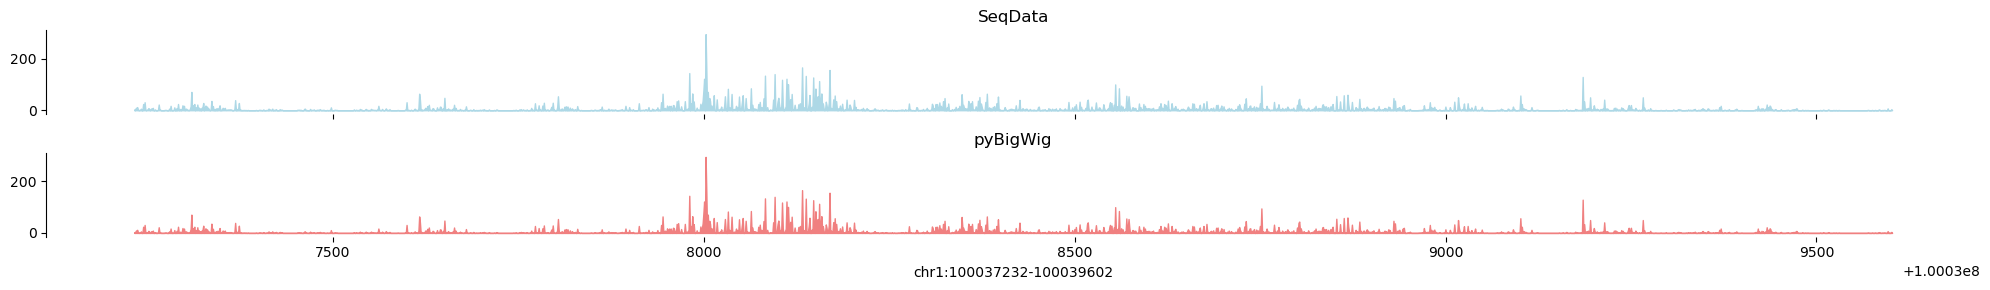

In [26]:
# Plot tracks
plot_tracks({
    "SeqData": sdata_vals,
    "pyBigWig": pybw_vals,
    }, 
    interval,
    colors={
        "SeqData": "lightblue",
        "pyBigWig": "lightcoral",
    }
)

# DONE!

---